In [1]:
# Load libraries
# Global Libraries
# Disable the warnings
import warnings

# Time series Models
from datetime import datetime

import numpy as np
import pandas as pd
import pandas_datareader.data as web

# Plotting
import seaborn as sns

# Libraries for Statistical Models
import statsmodels.api as sm
from matplotlib import pyplot
from pandas.plotting import scatter_matrix

# Regression ML
from sklearn.linear_model import LinearRegression

# Loss Function
from sklearn.metrics import mean_squared_error

# Modeling
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_val_score,
    train_test_split,
)
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures

warnings.filterwarnings("ignore")

In [2]:
# downloading the data
start = datetime(2007, 6, 30)
end = datetime(2022, 6, 30)

data = [
    "DGS1MO",
    "DGS3MO",
    "DGS1",
    "DGS2",
    "DGS5",
    "DGS7",
    "DGS10",
    "DGS30",
    "TREAST",  # -- U.S. Treasury securities held by the Federal Reserve ( Millions of Dollars )
    "FYGFDPUN",  # -- Federal Debt Held by the Public ( Millions of Dollars )
    "FDHBFIN",  # -- Federal Debt Held by Foreign and International Investors ( Billions of Dollars )
    "GFDEBTN",  # -- Federal Debt: Total Public Debt ( Millions of Dollars )
    "BAA10Y",  # -- Baa Corporate Bond Yield Relative to Yield on 10-Year
]
data = web.DataReader(data, "fred", start, end).dropna(how="all").ffill()
data["FDHBFIN"] = data["FDHBFIN"] * 1000
data["GOV_PCT"] = data["TREAST"] / data["GFDEBTN"]
data["HOM_PCT"] = data["FYGFDPUN"] / data["GFDEBTN"]
data["FOR_PCT"] = data["FDHBFIN"] / data["GFDEBTN"]

data.rename(
    columns={
        "DGS1MO": "1m",
        "DGS3MO": "3m",
        "DGS1": "1y",
        "DGS2": "2y",
        "DGS5": "5y",
        "DGS7": "7y",
        "DGS10": "10y",
        "DGS30": "30y",
    },
    inplace=True,
)
return_period = 5

Y = data.loc[:, ["1m", "5y", "30y"]].shift(-return_period)
Y.columns = [col + "_pred" for col in Y.columns]

X = data.loc[
    :,
    [
        "1m",
        "3m",
        "1y",
        "2y",
        "5y",
        "7y",
        "10y",
        "30y",
        "GOV_PCT",
        "HOM_PCT",
        "FOR_PCT",
        "BAA10Y",
    ],
]

df = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = df.loc[:, Y.columns]
X = df.loc[:, X.columns]

In [4]:
df.head(10)

,1m_pred,5y_pred,30y_pred,1m,3m,1y,2y,5y,7y,10y,30y,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2007-07-04,4.73,4.98,5.18,4.77,4.95,4.98,4.89,4.95,4.99,5.05,5.14,0.087765,0.56055,0.248156,1.60
2007-07-11,4.77,4.91,5.10,4.73,4.95,4.99,4.89,4.98,5.02,5.09,5.18,0.087770,0.56055,0.248156,1.59
2007-07-18,5.04,4.80,5.04,4.77,4.96,4.98,4.84,4.91,4.95,5.02,5.10,0.087776,0.56055,0.248156,1.58
2007-07-25,5.05,4.60,4.90,5.04,4.99,4.95,4.74,4.80,4.85,4.92,5.04,0.087782,0.56055,0.248156,1.65
2007-08-01,5.04,4.69,5.01,5.05,4.89,4.82,4.56,4.60,4.66,4.76,4.90,0.087792,0.56055,0.248156,1.86
2007-08-08,4.18,4.41,5.00,5.04,4.95,4.89,4.64,4.69,4.75,4.84,5.01,0.087794,0.56055,0.248156,1.87
2007-08-15,3.12,4.34,4.96,4.18,4.21,4.41,4.27,4.41,4.52,4.69,5.00,0.087659,0.56055,0.248156,2.03
2007-08-22,4.02,4.31,4.88,3.12,3.67,4.10,4.15,4.34,4.46,4.63,4.96,0.087661,0.56055,0.248156,2.07
2007-08-29,4.28,4.20,4.79,4.02,3.98,4.24,4.14,4.31,4.41,4.57,4.88,0.087108,0.56055,0.248156,2.05


In [5]:
print(Y)

            1m_pred  5y_pred  30y_pred
DATE                                  
2007-07-04     4.73     4.98      5.18
2007-07-11     4.77     4.91      5.10
2007-07-18     5.04     4.80      5.04
2007-07-25     5.05     4.60      4.90
2007-08-01     5.04     4.69      5.01
...             ...      ...       ...
2022-05-19     0.71     2.70      2.99
2022-05-26     0.87     2.95      3.11
2022-06-03     1.10     3.25      3.20
2022-06-10     1.15     3.34      3.30
2022-06-17     1.16     3.24      3.31

[756 rows x 3 columns]


In [6]:
print(X)

              1m    3m    1y    2y    5y    7y   10y   30y   GOV_PCT  \
DATE                                                                   
2007-07-04  4.77  4.95  4.98  4.89  4.95  4.99  5.05  5.14  0.087765   
2007-07-11  4.73  4.95  4.99  4.89  4.98  5.02  5.09  5.18  0.087770   
2007-07-18  4.77  4.96  4.98  4.84  4.91  4.95  5.02  5.10  0.087776   
2007-07-25  5.04  4.99  4.95  4.74  4.80  4.85  4.92  5.04  0.087782   
2007-08-01  5.05  4.89  4.82  4.56  4.60  4.66  4.76  4.90  0.087792   
...          ...   ...   ...   ...   ...   ...   ...   ...       ...   
2022-05-19  0.65  1.05  2.11  2.63  2.84  2.87  2.84  3.05  0.188691   
2022-05-26  0.71  1.07  1.99  2.46  2.70  2.75  2.75  2.99  0.188737   
2022-06-03  0.87  1.21  2.18  2.66  2.95  2.99  2.96  3.11  0.188781   
2022-06-10  1.10  1.39  2.58  3.06  3.25  3.24  3.15  3.20  0.188801   
2022-06-17  1.15  1.63  2.86  3.17  3.34  3.34  3.25  3.30  0.188518   

             HOM_PCT   FOR_PCT  BAA10Y  
DATE                  

## **3. Data Preparation**

The dataset in this exercise does not need much preprocessing, and therefore, we are going to use it as is. Note that data preparation involves transforming the data, for example, by scaling so that we remove bias when running machine learning algorithms on our datasets.

## **4. Modeling**

###  **4.1 Splitting the Dataset into Train and Test Samples**

We will split the data into $80\%$ for training (modeling) the dataset and $20\%$ to validate our model. To evaluate our algorithms, we choose the mean squared error since this is a regression exercise.

In [7]:
# split out validation dataset for model validation
test_size = 0.2

seed = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=test_size, random_state=seed
)

# test options for regression
num_folds = 10
scoring = "neg_mean_squared_error"

### **4.2 Forecasting Yield Curves: Fitting High Order Polynomials**
Linear regression assumes that there exists a linear relationship between the dependent and independent variables. To account for non-linearity in our dataset, we choose to employ polynomial regression by adding polynomial terms:
$$y = w_1 x + w_2 x^2 + \cdots + w_m x^m + b$$
where $m$ is the degree of our polynomial.

In our case study, we will compare the performance of 1-order, 2-order, and 3-order polynomial regressions. We use transformer `PoynomialFeatures` from scikit-learn to add quadratic terms.

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)

pred = lr.predict(X_test)

MSE = mean_squared_error(y_test, pred)

print("linear regression mean squared error:", MSE)

linear regression mean squared error: 0.015467226968099103


In [9]:
# Quadratic
poly = PolynomialFeatures(degree=2)
X_train2 = poly.fit_transform(X_train)
X_test2 = poly.fit_transform(X_test)

model = lr.fit(X_train2, y_train)
print(
    "quadratic regression mean squared error:",
    mean_squared_error(y_test, model.predict(X_test2)),
)

# Cubic
poly = PolynomialFeatures(degree=3)
X_train3 = poly.fit_transform(X_train)
X_test3 = poly.fit_transform(X_test)

model = lr.fit(X_train3, y_train)
print(
    "degree 3 polynomial regression mean squared error:",
    mean_squared_error(y_test, model.predict(X_test3)),
)

quadratic regression mean squared error: 0.03928591120675728
degree 3 polynomial regression mean squared error: 3.1369674787057575


### **4.3 Forecasting Yield Curves: Cross-Validation**
In $k$-fold cross-validation, data is split randomly into $k$ folds and without replacement. We train our data into $k-1$ folds and validate the model on the remaining one fold also called a test fold. The method is repeated $k$-terms, meaning we will have $k$ results. $k$-fold cross-validation is typically used for tuning our model.

We estimate the average performance $E$ by $$E = \frac{1}{k} \sum_{i=1}^k E_i$$

Cross-validation can be applied to any model, and we will therefore first discuss neural networks in the next subsection and apply cross-validation in our neural network algorithm to fine-tune its performance.

### **4.4 Forecasting Yield Curves - Backpropagation**

In the last lesson, we studied backpropagation in detail and we will put our skills to practice in this section. We will later apply an artificial neural network algorithm, (MLP), which is part of the machine learning library in `sklearn`.

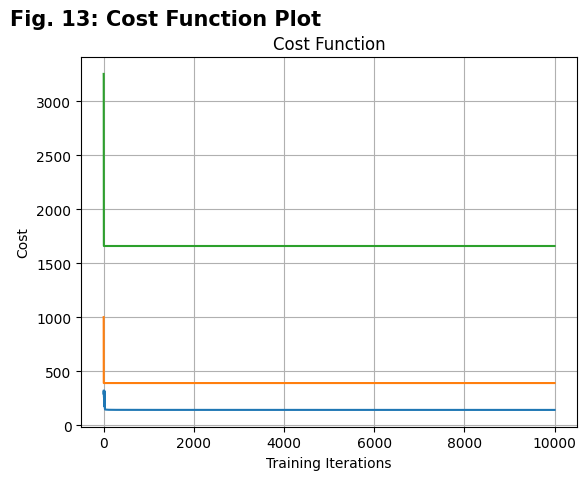

In [10]:
num_input = 12
num_hidden = 20
num_output = 3

W_x_h = np.random.randn(num_input, num_hidden)
b_h = np.zeros((1, num_hidden))

W_h_y = np.random.randn(num_hidden, num_output)
b_y = np.zeros((1, num_output))

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    return np.exp(-z) / ((1 + np.exp(-z)) ** 2)

def forward_prop(X, W_x_h, W_h_y):
    z_1 = np.dot(X, W_x_h) + b_h
    a_1 = sigmoid(z_1)
    z_2 = np.dot(a_1, W_h_y) + b_y
    y_hat = sigmoid(z_2)

    return z_1, a_1, z_2, y_hat

def back_prop(y_hat, z_1, a_1, z_2):
    delta2 = np.multiply(-(y_train - y_hat), sigmoid_derivative(z_2))
    dJ_d_W_h_y = np.dot(a_1.T, delta2)
    delta1 = np.dot(delta2, W_h_y.T) * sigmoid_derivative(z_1)
    dJ_d_W_x_h = np.dot(X_train.T, delta1)

    return dJ_d_W_x_h, dJ_d_W_h_y

def cost_function(y, y_pred):
    return 0.5 * np.sum((y - y_pred) ** 2)

alpha = 0.01
num_iterations = 10000

cost = []

for i in range(num_iterations):
    z_1, a_1, z_2, y_hat = forward_prop(X_train, W_x_h, W_h_y)
    dJ_d_W_x_h, dJ_d_W_h_y = back_prop(y_hat, z_1, a_1, z_2)

    # update weights
    W_x_h = W_x_h - alpha * dJ_d_W_x_h
    W_h_y = W_h_y - alpha * dJ_d_W_h_y

    # compute cost
    c = cost_function(y_train, y_hat)

    cost.append(c)
    
pyplot.grid()
pyplot.plot(range(num_iterations), cost)

pyplot.title("Cost Function")
pyplot.xlabel("Training Iterations")
pyplot.ylabel("Cost")
pyplot.suptitle(
    "Fig. 13: Cost Function Plot",
    fontweight="bold",
    horizontalalignment="right",
    fontsize=15,
)
pyplot.show()

In [11]:
# test options for regression
num_folds = 10
scoring = "neg_mean_squared_error"

# spot check the algorithms
models = []

# Linear Regression Algorithm
models.append(("LR", LinearRegression()))

# Deep Learning Algorithm
models.append(("MLP", MLPRegressor()))

kfold_results = []
names = []
validation_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    # converted mean square error to positive. The lower the better
    cv_results = -1 * cross_val_score(
        model, X_train, y_train, cv=kfold, scoring=scoring
    )
    kfold_results.append(cv_results)
    names.append(name)

    # Finally we Train on the full period and test against validation
    res = model.fit(X_train, y_train)
    validation_result = np.mean(np.square(res.predict(X_test) - y_test))
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train) - y_train))
    train_results.append(train_result)

    msg = (
        "%s: \nAverage CV error: %s \nStd CV Error: (%s) \nTraining Error:\n%s \nTest Error:\n%s"
        % (
            name,
            str(cv_results.mean()),
            str(cv_results.std()),
            str(train_result),
            str(validation_result),
        )
    )
    print(msg)
    print("----------")

LR: 
Average CV error: 0.013481906943107242 
Std CV Error: (0.004964996907688882) 
Training Error:
0.012399694169292581 
Test Error:
0.015467226968099105
----------
MLP: 
Average CV error: 0.01737035090197899 
Std CV Error: (0.007261734014626672) 
Training Error:
0.015868082557882624 
Test Error:
0.018892937532279396
----------


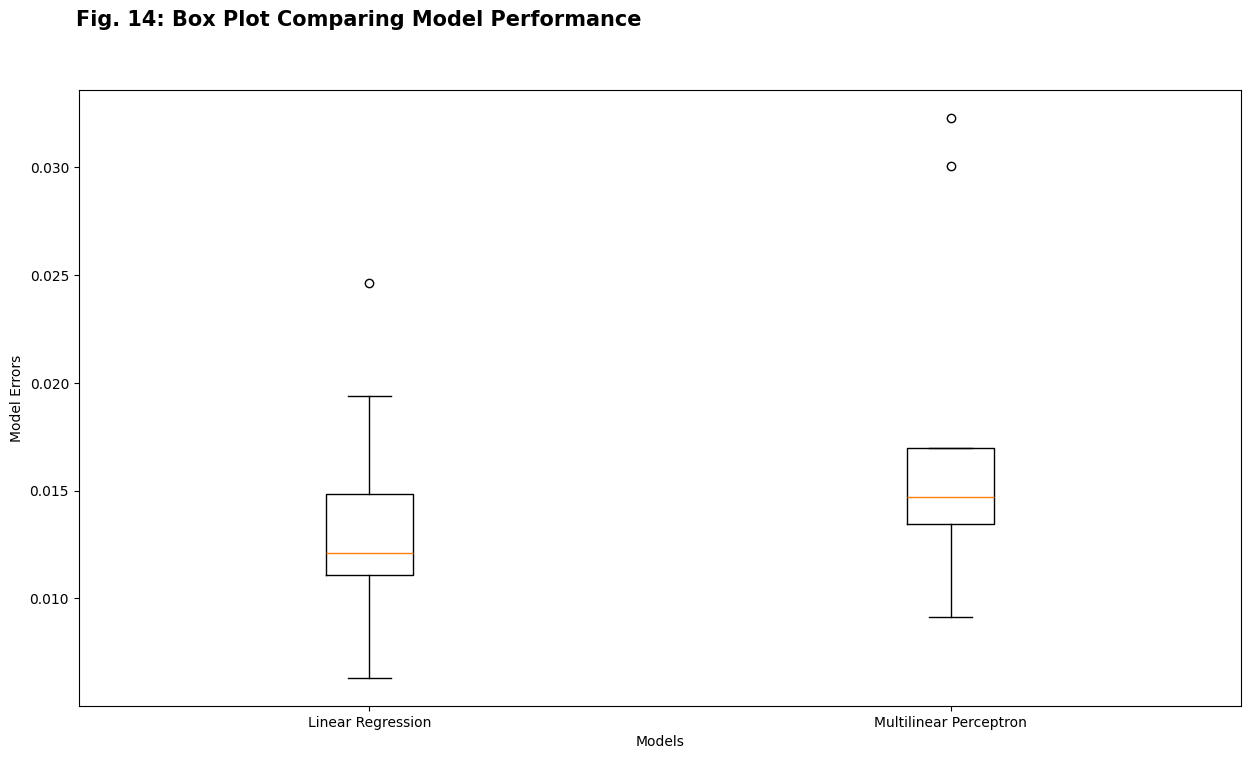

In [12]:
# compare algorithms
names = ["Linear Regression", "Multilinear Perceptron"]
fig = pyplot.figure()
# print('\033[1m' + 'Fig 14: Box Plot Comparing Model Performance' + '\033[0m' )
fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
pyplot.ylabel("Model Errors")
pyplot.xlabel("Models")
pyplot.suptitle(
    "Fig. 14: Box Plot Comparing Model Performance",
    fontweight="bold",
    horizontalalignment="right",
    fontsize=15,
)
pyplot.show()

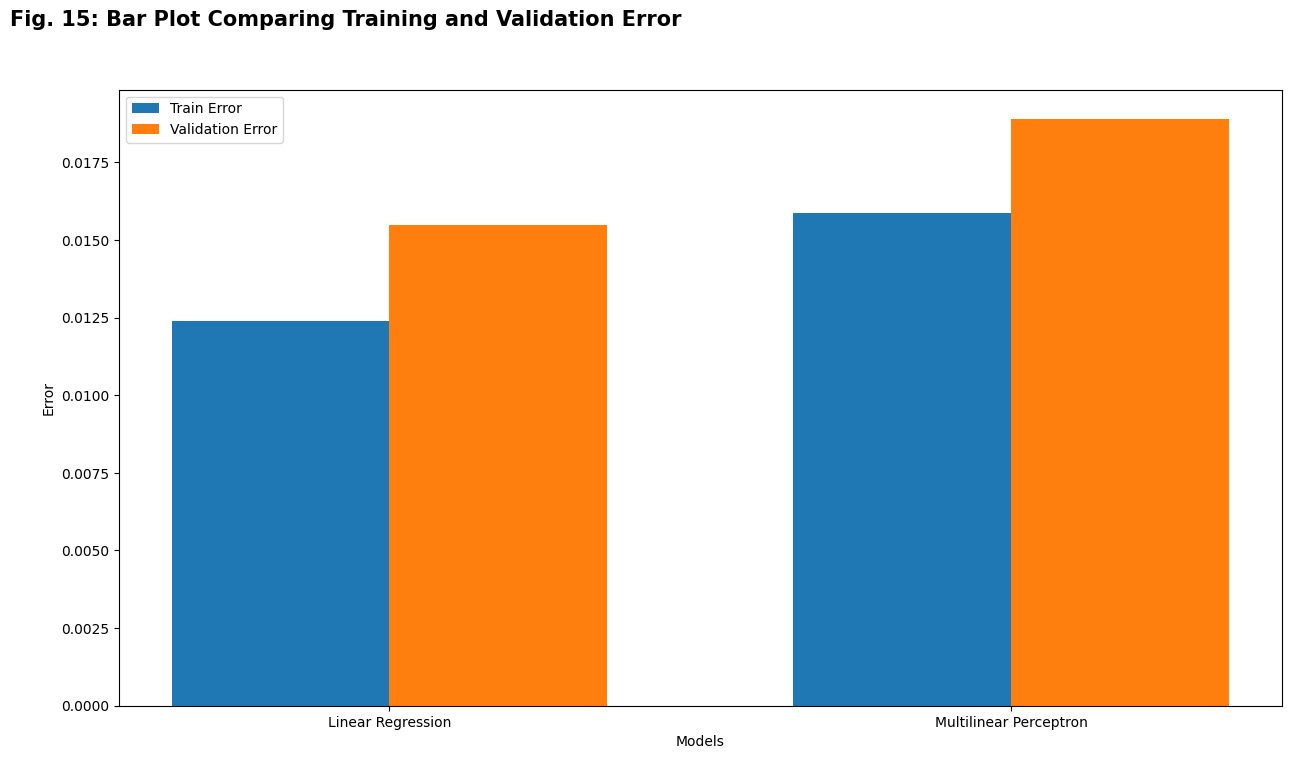

In [13]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
pyplot.bar(
    ind - width / 2, [x.mean() for x in train_results], width=width, label="Train Error"
)
pyplot.bar(
    ind + width / 2,
    [x.mean() for x in validation_results],
    width=width,
    label="Validation Error",
)
fig.set_size_inches(15, 8)
pyplot.legend()
pyplot.ylabel("Error")
pyplot.xlabel("Models")
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.suptitle(
    "Fig. 15: Bar Plot Comparing Training and Validation Error",
    fontweight="bold",
    horizontalalignment="right",
    fontsize=15,
)
pyplot.show()

In [14]:
# Grid search : `MLPRegressor`
"""
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
"""
param_grid = {"hidden_layer_sizes": [(20,), (50,), (20, 20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]

Best: -0.020874 using {'hidden_layer_sizes': (50,)}


In [15]:
# prepare model
model = MLPRegressor(hidden_layer_sizes=(20, 30, 20))
model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(20, 30, 20))

In [16]:
# estimate accuracy on validation set
from sklearn.metrics import mean_squared_error, r2_score

predictions = model.predict(X_test)
mse_MLP = mean_squared_error(y_test, predictions)
r2_MLP = r2_score(y_test, predictions)

# prepare model
model_2 = LinearRegression()
model_2.fit(X_train, y_train)
predictions_2 = model_2.predict(X_test)

mse_OLS = mean_squared_error(y_test, predictions_2)
r2_OLS = r2_score(y_test, predictions_2)
print("MSE Regression = %f, MSE MLP = %f" % (mse_OLS, mse_MLP))
print("R2 Regression = %f, R2 MLP = %f" % (r2_OLS, r2_MLP))

MSE Regression = 0.015467, MSE MLP = 0.018499
R2 Regression = 0.979860, R2 MLP = 0.975707


<function matplotlib.pyplot.show(close=None, block=None)>

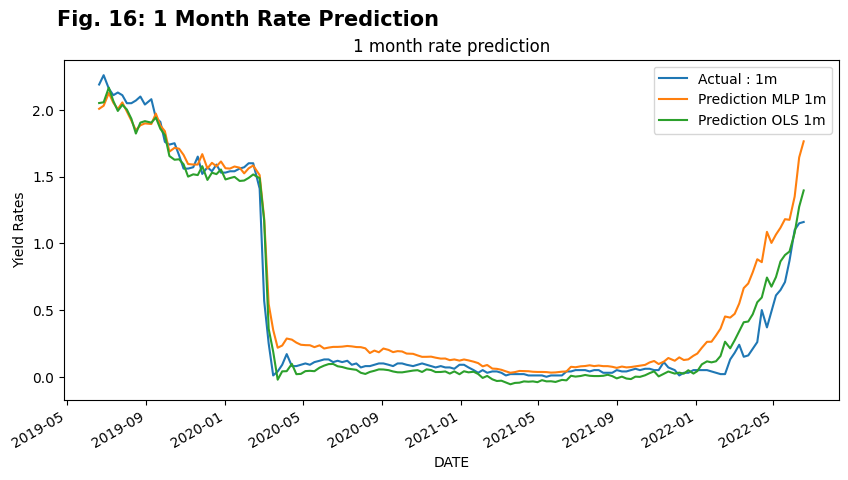

In [17]:
train_size = int(len(X) * (1 - test_size))
X_train, X_test = X[0:train_size], X[train_size : len(X)]
y_train, y_test = Y[0:train_size], Y[train_size : len(X)]

modelMLP = MLPRegressor(hidden_layer_sizes=(50,))
modelOLS = LinearRegression()
model_MLP = modelMLP.fit(X_train, y_train)
model_OLS = modelOLS.fit(X_train, y_train)

Y_predMLP = pd.DataFrame(
    model_MLP.predict(X_test), index=y_test.index, columns=y_test.columns
)

Y_predOLS = pd.DataFrame(
    model_OLS.predict(X_test), index=y_test.index, columns=y_test.columns
)

pd.DataFrame(
    {
        "Actual : 1m": y_test.loc[:, "1m_pred"],
        "Prediction MLP 1m": Y_predMLP.loc[:, "1m_pred"],
        "Prediction OLS 1m": Y_predOLS.loc[:, "1m_pred"],
    }
).plot(figsize=(10, 5))
pyplot.title("1 month rate prediction")
pyplot.ylabel("Yield Rates")
pyplot.suptitle(
    "Fig. 16: 1 Month Rate Prediction",
    fontweight="bold",
    horizontalalignment="right",
    fontsize=15,
)
pyplot.show

<function matplotlib.pyplot.show(close=None, block=None)>

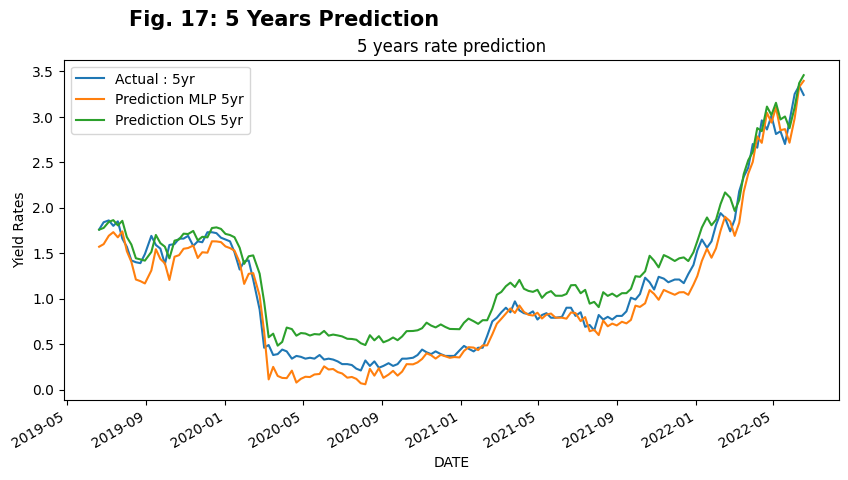

In [18]:
pd.DataFrame(
    {
        "Actual : 5yr": y_test.loc[:, "5y_pred"],
        "Prediction MLP 5yr": Y_predMLP.loc[:, "5y_pred"],
        "Prediction OLS 5yr": Y_predOLS.loc[:, "5y_pred"],
    }
).plot(figsize=(10, 5))
pyplot.title("5 years rate prediction")
pyplot.ylabel("Yield Rates")
pyplot.suptitle(
    "Fig. 17: 5 Years Prediction",
    fontweight="bold",
    horizontalalignment="right",
    fontsize=15,
)
pyplot.show

<function matplotlib.pyplot.show(close=None, block=None)>

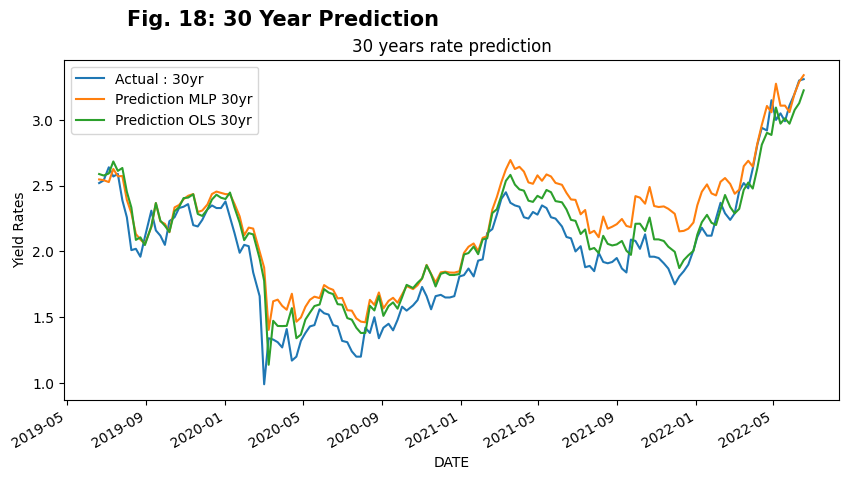

In [19]:
pd.DataFrame(
    {
        "Actual : 30yr": y_test.loc[:, "30y_pred"],
        "Prediction MLP 30yr": Y_predMLP.loc[:, "30y_pred"],
        "Prediction OLS 30yr": Y_predOLS.loc[:, "30y_pred"],
    }
).plot(figsize=(10, 5))
pyplot.title("30 years rate prediction")
pyplot.ylabel("Yield Rates")
pyplot.suptitle(
    "Fig. 18: 30 Year Prediction",
    fontweight="bold",
    horizontalalignment="right",
    fontsize=15,
)
pyplot.show